In [1]:
import os
import readData
import objects
from types import SimpleNamespace
import numpy as np
from matplotlib import pyplot as plt

In [2]:
cwd = os.getcwd()
dataPath = os.path.join('c:\\Users\\vkuma\\Research\\', 'Data', 'CleanData', 'movie009.txt')
dataVect, dataVectIndex, deltaT = readData.dataReader(dataPath, 1)
dataVect = dataVect*97

In [3]:
#declare variables as instance of SimpleNamespace
variables = SimpleNamespace(**objects.PARAMETERS)

data = SimpleNamespace(**objects.DATA)
data.trajectoriesIndex = dataVectIndex
data.trajectories = dataVect
data.deltaT = deltaT
data.nData = len(data.trajectoriesIndex)
data.nTrajectories = np.unique(data.trajectoriesIndex)

#pull necassary variables
trajectories = data.trajectories
nData = data.nData
nTraj = data.nTrajectories
trajectoriesIndex = data.trajectoriesIndex
nInduX = 30
nInduY = 30
nFineX = variables.nFineX
nFineY = variables.nFineY
epsilon = variables.epsilon
deltaT = data.deltaT
dataX = trajectories[:,0]
dataY = trajectories[:,1]
minX = min(dataX)
minY = min(dataY)
maxX = max(dataX)
maxY = max(dataY)
nIndu = nInduX*nInduY
covL = variables.covL
covLambda = variables.covLambda

In [4]:
#Points of trajectory where learning is possible
dataCoordinates = np.empty((0,2))
for i in range(nData-1):
    if (trajectoriesIndex[i] == trajectoriesIndex[i+1]):
        dataCoordinates = np.vstack((dataCoordinates, trajectories[i]))

#Points of trajectory that are "sampled"
sampleCoordinates = np.empty((0,2))
for i in range(1,nData):
    if (trajectoriesIndex[i] == trajectoriesIndex[i-1]):
        sampleCoordinates = np.vstack((sampleCoordinates, trajectories[i]))

In [10]:
#Initial Guess with MLE
diff = sampleCoordinates - dataCoordinates
num = np.sum(diff * diff)
den = 4*deltaT*len(diff)
mle = num/den
dIndu = mle * np.ones(nIndu)
priorMean = dIndu.copy()

#Estimate Hyperparameters if not chosen by user
if covL == None:
    covL = np.max([maxX-minX, maxY-minY]) * 0.1
if covLambda == None:
    covLambda = mle/10

#define coordinates for Inducing points
xIndu = np.linspace(minX-covL, maxX+covL, nInduX)
yIndu = np.linspace(minY-covL, maxY+covL, nInduY)
xTemp, yTemp = np.meshgrid(xIndu, yIndu)
X = np.reshape(xTemp, -1)
Y = np.reshape(yTemp, -1)
induCoordinates = np.vstack((X, Y)).T

#define coordinates for Fine points
xFine = np.linspace(minX, maxX, nFineX)
yFine = np.linspace(minY, maxY, nFineY)
xTemp, yTemp = np.meshgrid(xFine, yFine)
X = np.reshape(xTemp, -1)
Y = np.reshape(yTemp, -1)
fineCoordinates = np.vstack((X, Y)).T

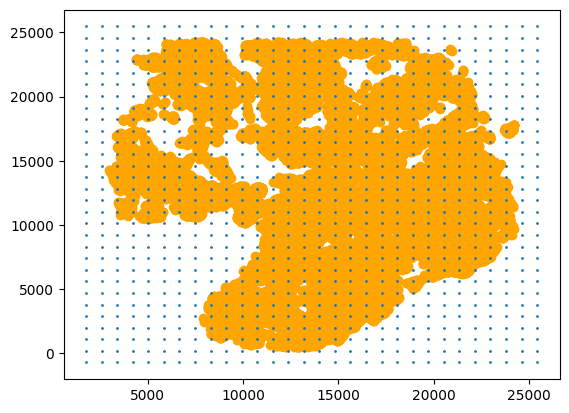

In [11]:
plt.scatter(dataCoordinates[:,0], dataCoordinates[:,1], label = "data", color = "orange")
plt.scatter(induCoordinates[:,0], induCoordinates[:,1], label = "original inducing points", s =1)

In [12]:
remove1 = []
for i in xIndu:
    for j in induCoordinates[np.where(induCoordinates[:,0] == i)]:
        if(np.min(np.linalg.norm(dataCoordinates-j, axis=1)) >= 0.67*covL):
            remove1.append(j)
        else:
            break
for i in yIndu:
    for j in induCoordinates[np.where(induCoordinates[:,1] == i)]:
        if(np.min(np.linalg.norm(dataCoordinates-j, axis=1)) >= 0.67*covL):
            remove1.append(j)
        else:
            break
for i in xIndu:
    for j in reversed(induCoordinates[np.where(induCoordinates[:,0] == i)]):
        if(np.min(np.linalg.norm(dataCoordinates-j, axis=1)) >= 0.67*covL):
            remove1.append(j)
        else:
            break
for i in yIndu:
    for j in reversed(induCoordinates[np.where(induCoordinates[:,1] == i)]):
        if(np.min(np.linalg.norm(dataCoordinates-j, axis=1)) >= 0.67*covL):
            remove1.append(j)
        else:
            break
indicies = []
for i in remove1:    
    indicies.append(np.where(np.all(induCoordinates==i,axis=1))[0][0])
induCoordinatesNew = np.delete(induCoordinates, indicies, axis = 0)

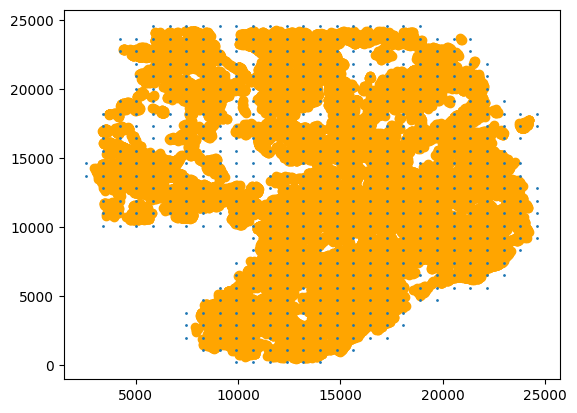

In [13]:
plt.scatter(dataCoordinates[:,0], dataCoordinates[:,1], label = "data", color = "orange")
plt.scatter(induCoordinatesNew[:,0], induCoordinatesNew[:,1], label = "New inducing points", s =1)

In [14]:
len(induCoordinatesNew)

576

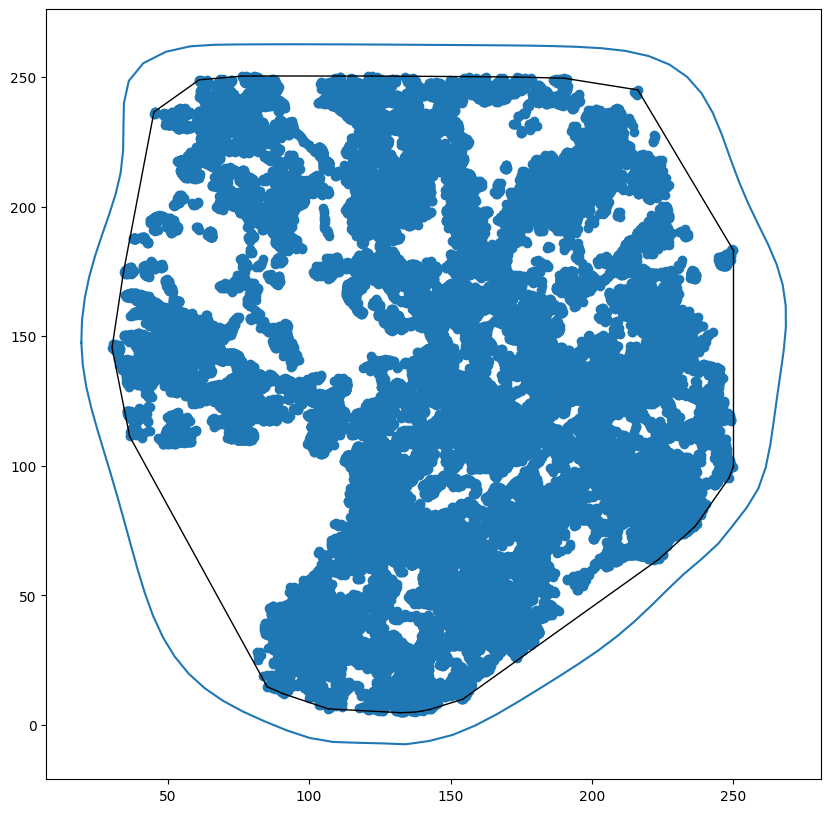

In [25]:
import sklearn.preprocessing
import sklearn.pipeline
import scipy.spatial
import numpy as np


def calculate_hull(
        X, 
        scale=1.1, 
        padding="scale", 
        n_interpolate=100, 
        interpolation="quadratic_periodic", 
        return_hull_points=False):
    """
    Calculates a "smooth" hull around given points in `X`.
    The different settings have different drawbacks but the given defaults work reasonably well.
    Parameters
    ----------
    X : np.ndarray
        2d-array with 2 columns and `n` rows
    scale : float, optional
        padding strength, by default 1.1
    padding : str, optional
        padding mode, by default "scale"
    n_interpolate : int, optional
        number of interpolation points, by default 100
    interpolation : str or callable(ix,iy,x), optional
        interpolation mode, by default "quadratic_periodic"

    Inspired by: https://stackoverflow.com/a/17557853/991496
    """
    
    if padding == "scale":

        # scaling based padding
        scaler = sklearn.pipeline.make_pipeline(
            sklearn.preprocessing.StandardScaler(with_std=False),
            sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1)))
        points_scaled = scaler.fit_transform(X) * scale
        hull_scaled = scipy.spatial.ConvexHull(points_scaled, incremental=True)
        hull_points_scaled = points_scaled[hull_scaled.vertices]
        hull_points = scaler.inverse_transform(hull_points_scaled)
        hull_points = np.concatenate([hull_points, hull_points[:1]])
    
    elif padding == "extend" or isinstance(padding, (float, int)):
        # extension based padding
        # TODO: remove?
        if padding == "extend":
            add = (scale - 1) * np.max([
                X[:,0].max() - X[:,0].min(), 
                X[:,1].max() - X[:,1].min()])
        else:
            add = padding
        points_added = np.concatenate([
            X + [0,add], 
            X - [0,add], 
            X + [add, 0], 
            X - [add, 0]])
        hull = scipy.spatial.ConvexHull(points_added)
        hull_points = points_added[hull.vertices]
        hull_points = np.concatenate([hull_points, hull_points[:1]])
    else:
        raise ValueError(f"Unknown padding mode: {padding}")
    
    # number of interpolated points
    nt = np.linspace(0, 1, n_interpolate)
    
    x, y = hull_points[:,0], hull_points[:,1]
    
    # ensures the same spacing of points between all hull points
    t = np.zeros(x.shape)
    t[1:] = np.sqrt((x[1:] - x[:-1])**2 + (y[1:] - y[:-1])**2)
    t = np.cumsum(t)
    t /= t[-1]

    # interpolation types
    if interpolation is None or interpolation == "linear":
        x2 = scipy.interpolate.interp1d(t, x, kind="linear")(nt)
        y2 = scipy.interpolate.interp1d(t, y, kind="linear")(nt)
    elif interpolation == "quadratic":
        x2 = scipy.interpolate.interp1d(t, x, kind="quadratic")(nt)
        y2 = scipy.interpolate.interp1d(t, y, kind="quadratic")(nt)

    elif interpolation == "quadratic_periodic":
        x2 = scipy.interpolate.splev(nt, scipy.interpolate.splrep(t, x, per=True, k=4))
        y2 = scipy.interpolate.splev(nt, scipy.interpolate.splrep(t, y, per=True, k=4))
    
    elif interpolation == "cubic":
        x2 = scipy.interpolate.CubicSpline(t, x, bc_type="periodic")(nt)
        y2 = scipy.interpolate.CubicSpline(t, y, bc_type="periodic")(nt)
    else:
        x2 = interpolation(t, x, nt)
        y2 = interpolation(t, y, nt)
    
    X_hull = np.concatenate([x2.reshape(-1,1), y2.reshape(-1,1)], axis=1)
    if return_hull_points:
        return X_hull, hull_points
    else:
        return X_hull


def draw_hull(
        X, 
        scale=1.1, 
        padding="scale", 
        n_interpolate=100, 
        interpolation="quadratic_periodic",
        plot_kwargs=None, 
        ax=None):
    """Uses `calculate_hull` to draw a hull around given points.

    Parameters
    ----------
    X : np.ndarray
        2d-array with 2 columns and `n` rows
    scale : float, optional
        padding strength, by default 1.1
    padding : str, optional
        padding mode, by default "scale"
    n_interpolate : int, optional
        number of interpolation points, by default 100
    interpolation : str or callable(ix,iy,x), optional
        interpolation mode, by default "quadratic_periodic"
    plot_kwargs : dict, optional
        `matplotlib.pyplot.plot` kwargs, by default None
    ax : `matplotlib.axes.Axes`, optional
        [description], by default None
    """

    if plot_kwargs is None:
        plot_kwargs = {}

    X_hull = calculate_hull(
        X, scale=scale, padding=padding, n_interpolate=n_interpolate, interpolation=interpolation)
    if ax is None:
        ax= plt.gca()
    plt.plot(X_hull[:,0], X_hull[:,1], **plot_kwargs)


def draw_rounded_hull(X, padding=0.1, line_kwargs=None, ax=None):
    """Plots a convex hull around points with rounded corners and a given padding.

    Parameters
    ----------
    X : np.array
        2d array with two columns and n rows
    padding : float, optional
        padding between hull and points, by default 0.1
    line_kwargs : dict, optional
        line kwargs (used for `matplotlib.pyplot.plot` and `matplotlib.patches.Arc`), by default None
    ax : matplotlib.axes.Axes, optional
        axes to plat on, by default None
    """

    default_line_kwargs = dict(
        color="black",
        linewidth=1
    )
    if line_kwargs is None:
        line_kwargs = default_line_kwargs
    else:
        line_kwargs = {**default_line_kwargs, **line_kwargs}

    if ax is None:
        ax = plt.gca()

    hull = scipy.spatial.ConvexHull(X)
    hull_points = X[hull.vertices]

    hull_points = np.concatenate([hull_points[[-1]], hull_points, hull_points[[0]]])

    diameter = padding * 2
    for i in range(1, hull_points.shape[0] - 1):

        # line
        
        # source: https://stackoverflow.com/a/1243676/991496
        
        norm_next = np.flip(hull_points[i] - hull_points[i + 1]) * [-1, 1]
        norm_next /= np.linalg.norm(norm_next)

        norm_prev = np.flip(hull_points[i - 1] - hull_points[i]) * [-1, 1]
        norm_prev /= np.linalg.norm(norm_prev)

        # plot line
        line = hull_points[i:i+2] + norm_next * diameter / 2
        ax.plot(line[:,0], line[:,1], **line_kwargs) 

        # arc

        angle_next = np.rad2deg(np.arccos(np.dot(norm_next, [1,0])))
        if norm_next[1] < 0:
            angle_next = 360 - angle_next

        angle_prev = np.rad2deg(np.arccos(np.dot(norm_prev, [1,0])))
        if norm_prev[1] < 0:
            angle_prev = 360 - angle_prev

        arc = patches.Arc(
            hull_points[i], 
            diameter, diameter,
            angle=0, fill=False, theta1=angle_prev, theta2=angle_next,
            **line_kwargs)

        ax.add_patch(arc)


if __name__ == '__main__':

    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import patches

    # np.random.seed(42)
    X = dataVect

    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.scatter(X[:,0], X[:,1])
    draw_rounded_hull(X, padding=0.1)
    draw_hull(X)

In [30]:
from scipy.spatial import Delaunay
import numpy as np


def alpha_shape(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add an edge between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

C:\Users\vkuma\AppData\Local\Temp\ipykernel_21036\2289174364.py:11: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  edges = alpha_shape(points, alpha=15, only_outer=True)


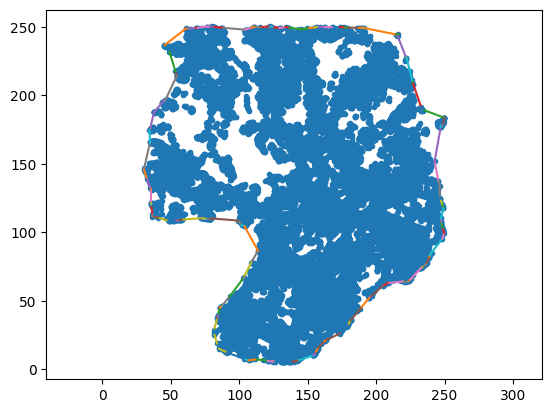

In [43]:
from matplotlib.pyplot import *

# Constructing the input point data
np.random.seed(0)
x = dataVect[:,0]
y = dataVect[:,1]
inside = ((x ** 2 + y ** 2 > 1.0) & ((x - 3) ** 2 + y ** 2 > 1.0))
points = np.vstack([x[inside], y[inside]]).T

# Computing the alpha shape
edges = alpha_shape(points, alpha=15, only_outer=True)

# Plotting the output
figure()
axis('equal')
plot(points[:, 0], points[:, 1], '.')
for i, j in edges:
    plot(points[[i, j], 0], points[[i, j], 1])
show()

In [233]:
from matplotlib.pyplot import *

# Constructing the input point data
np.random.seed(0)
x = dataVect[:, 0]
y = dataVect[:, 1]
inside = ((x ** 2 + y ** 2 > 1.0) & ((x - 3) ** 2 + y ** 2 > 1.0))
points = np.vstack([x[inside], y[inside]]).T

# Computing the alpha shape
edges = alpha_shape(points, alpha=15, only_outer=True)

# Extracting the indices of points forming the edges
edge_indices = np.unique(edges)

# Removing inducing points outside the edges
induCoordinatesNew = induCoordinates[edge_indices]

# Plotting the output
figure()
axis('equal')
plot(points[:, 0], points[:, 1], '.')
for i, j in edges:
    plot(points[[i, j], 0], points[[i, j], 1])
show()

C:\Users\vkuma\AppData\Local\Temp\ipykernel_21036\1568987141.py:11: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  edges = alpha_shape(points, alpha=15, only_outer=True)


IndexError: arrays used as indices must be of integer (or boolean) type

In [10]:
edge_indices

NameError: name 'edge_indices' is not defined

In [234]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Generate fake data
x = dataVect[:,0]
y = dataVect[:,1]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.show()

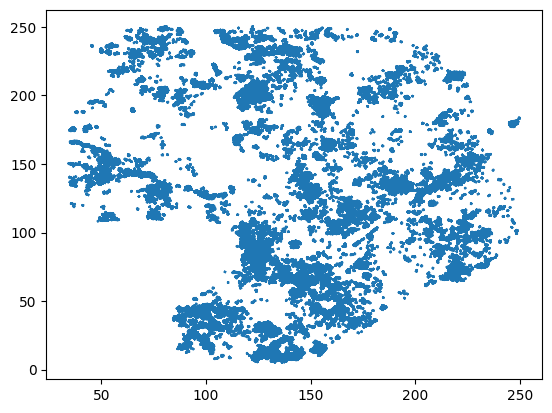

In [37]:
from scipy.spatial import Delaunay

points = dataVect

tri = Delaunay(points,furthest_site=False)
res = []
for t in tri.simplices:
  A,B,C = points[t[0]],points[t[1]],points[t[2]]
  e1 = B-A; e2 = C-A
  num = np.dot(e1, e2)
  n1 = np.linalg.norm(e1); n2 = np.linalg.norm(e2)
  denom =  n1 * n2
  d1 = np.rad2deg(np.arccos(num/denom))
  e1 = C-B; e2 = A-B
  num = np.dot(e1, e2)
  denom = np.linalg.norm(e1) * np.linalg.norm(e2)
  d2 = np.rad2deg(np.arccos(num/denom))
  d3 = 180-d1-d2
  res.append([n1,n2,d1,d2,d3])

res = np.array(res)
m = res[:,[0,1]].mean()*res[:,[0,1]].std()

mask = np.any(res[:,[2,3,4]] > 110) & (res[:,0] < m) & (res[:,1] < m )

plt.triplot(points[:,0], points[:,1], tri.simplices[mask])

In [2]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
#import functions
#import objects
from types import SimpleNamespace
#import syntheticDataGenerator
import matplotlib
from matplotlib import cm
import ast
import h5py
import pickle as pkl
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
def dataReader(path, num):
    
    #to reduce runtime and memeory needs we only take nth element from the data
    n = num
    
    #read datafile
    with open(path) as inp:
        tempData = [i.strip().split('\t') for i in inp]

    #clean the data
    cleanData = []
    for i in tempData:
        if i != ['']:
            cleanData.append(i)
    
    #coordinates for trajectories
    x = np.array([float(i[3]) for i in cleanData])
    y = np.array([float(i[4]) for i in cleanData])

    #save organized dat in respective vectors
    dataVect = np.vstack((x,y)).T
    dataVectIndex = np.array([int(i[1]) for i in cleanData])
    
    #sub sample
    dataVect = dataVect[::n]
    dataVectIndex = dataVectIndex[::n]
    
    #put time step manually as unavailable from data file
    deltaT = (1/30)*n

    #print('We only used every ' + str(n) + 'th datapoint')
    return dataVect, dataVectIndex, deltaT

In [21]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create some sample data
x = [1, 2, 3, 4, 5]
y = [2, 4, 6, 8, 10]
z = [3, 6, 9, 12, 15]

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data as a scatter plot
ax.scatter(x, y, z)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Interactive 3D Plot')

# Display the plot
plt.show()


<IPython.core.display.Javascript object>

In [3]:
# Calculate probabilities of induced samples
def probability(dIndu_, dData_):
    
    # Prior
    diff = dIndu_ - priorMean
    prior = -0.5*(diff.T @ (cInduInduInv @ diff))
    
    #Likelihood of that data
    lhood = 0
    for i in range(samples.shape[0]):
        for j in range(samples.shape[1]):
            lhood += (
                -.5 * (samples[i, j] - means[i, j])**2 / (2*dData_[j]*deltaT)
                - .5 * np.log(2*np.pi*2*dData_[j]*deltaT)
            )
    prob = lhood + prior

    return prob

In [4]:
 # Define probability of inducing points
def probability1(dIndu_, dData_):

    # Prior
    diff = dIndu_ - priorMean
    prior =  -0.5*(diff.T @ (cInduInduInv @ diff))
    
    #Likelihood of that data
    lhood = np.sum(
        stats.norm.logpdf(
            samples,
            loc=means,
            scale=np.sqrt(2*np.vstack((dData_, dData_)).T*deltaT)
        )
    )
    prob = lhood + prior

    return prob

In [3]:
file = open("C:\\Users\\vkuma\\Downloads\\200000 1 1999.9119199787813variables.pkl", "rb")
variables = pkl.load(file)
file = open("C:/Users/vkuma/Research/LearningDiffusionMaps/1000 1 1999.9119199787813data.pkl", "rb")
data = pkl.load(file)

In [6]:
variables

namespace(nInduX=50,
          nInduY=50,
          nFineX=100,
          nFineY=100,
          dataCoordinates=array([[ 7647.52114926,  7792.10524414],
                                 [ 7570.91656368,  7753.27337678],
                                 [ 7662.5989301 ,  7840.33166041],
                                 ...,
                                 [14673.17096069, 15328.18225775],
                                 [14710.11726827, 15399.50656459],
                                 [14663.92493378, 15411.64739748]]),
          sampleCoordinates=array([[ 7570.91656368,  7753.27337678],
                                   [ 7662.5989301 ,  7840.33166041],
                                   [ 7667.21908281,  7851.2599919 ],
                                   ...,
                                   [14710.11726827, 15399.50656459],
                                   [14663.92493378, 15411.64739748],
                                   [14584.14557545, 15397.1200031 ]]),
          induCo

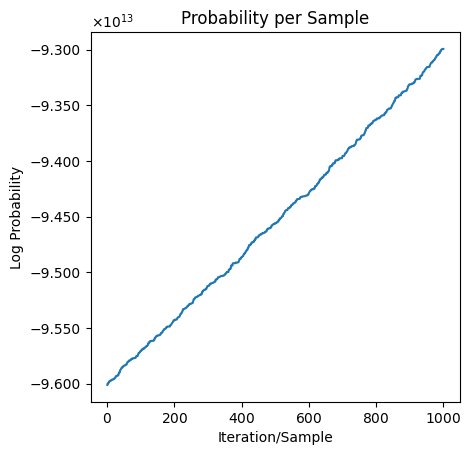

In [5]:
file = "C:/Users/vkuma/Research/LearningDiffusionMaps/1000(1 1999.9119199787813).h5"
f = h5py.File(file, 'r')
dVect= f['samples'][()]
pVect = f['prob'][()]
fig, ax = plt.subplots(1, 1)
plt.plot(pVect)
plt.title("Probability per Sample")
plt.xlabel("Iteration/Sample")
plt.ylabel("Log Probability")
plt.ticklabel_format(useMathText=True)
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter)
class ScalarFormatterClass(ticker.ScalarFormatter):
   def _set_format(self):
      self.format = "%1.3f"
yScalarFormatter = ScalarFormatterClass(useMathText=True)
yScalarFormatter.set_powerlimits((0,0))
ax.yaxis.set_major_formatter(yScalarFormatter)
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')


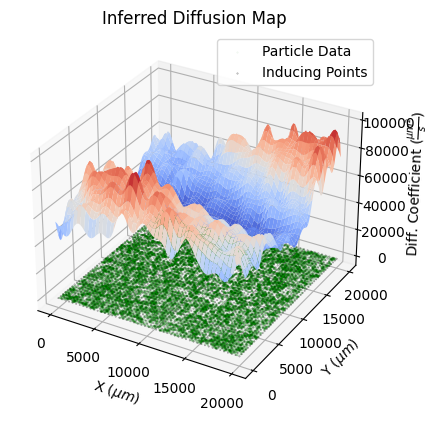

interactive(children=(IntSlider(value=45, description='elevation', max=90, step=5), IntSlider(value=0, descrip…

C:\Users\vkuma\AppData\Local\Temp\ipykernel_15376\3742743997.py:49: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(surf, shrink=0.5, anchor=(0.5, 0.5))


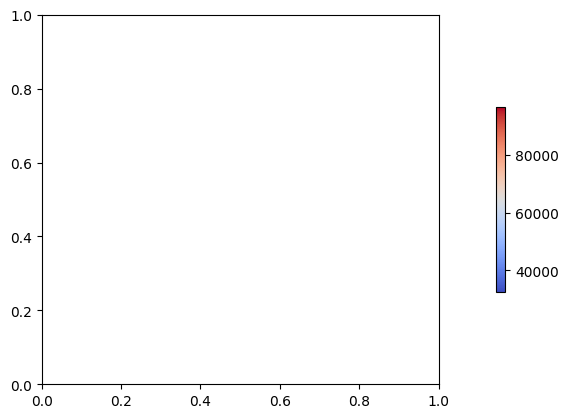

In [7]:
#necassary variables
nFineX = variables.nFineX
nFineY = variables.nFineY
cInduFine = variables.cInduFine
cInduInduInv = variables.cInduInduInv
fineCoordinates = variables.fineCoordinates
trajectories = data.trajectories
induCoordinates = variables.induCoordinates 

#shape for plot
shape = (nFineX, nFineY)

#take mean of all samples
unshapedMap = (cInduFine.T @ (cInduInduInv @ dVect[0]))

#reshape variables to make plotting easy
shapedMap = np.reshape(unshapedMap, shape)
shapedX = np.reshape(fineCoordinates[:,0], shape)
shapedY = np.reshape(fineCoordinates[:,1], shape)


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.colors
from ipywidgets import interact

# Generate contour plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(shapedX, shapedY, shapedMap, cmap=cm.coolwarm)
scatter_particles = ax.scatter(trajectories[:, 0], trajectories[:, 1], 0, color="green", alpha=0.1, label="Particle Data", s = 0.1)
scatter_inducing = ax.scatter(induCoordinates[:, 0], induCoordinates[:, 1], 0, color="black", alpha=0.5, label="Inducing Points", s=0.1)
ax.set_xlabel(r"X ($\mu m$)")
ax.set_ylabel(r"Y ($\mu m$)")
ax.set_zlabel(r"Diff. Coefficient ($\frac{\mu m^2}{s}$)")
ax.set_title("Inferred Diffusion Map")
ax.legend()

# Create a function to update the contour plot based on parameters
def update_plot(elevation, azimuth):
    ax.view_init(elev=elevation, azim=azimuth)

# Create an interactive widget for the plot
interact(update_plot, elevation=(0, 90, 5), azimuth=(-180, 180, 10))

# Display the plot
plt.colorbar(surf, shrink=0.5, anchor=(0.5, 0.5))
plt.show()

In [23]:
plt.show()

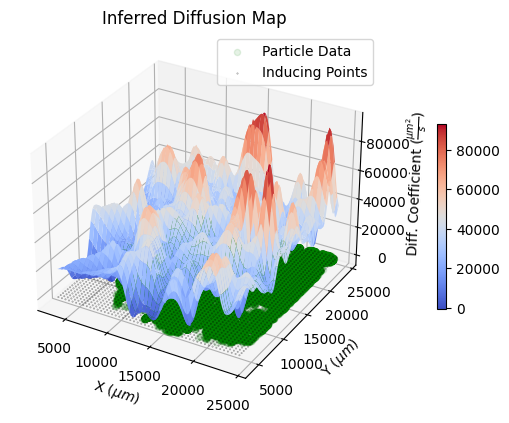

In [16]:
#necassary variables
nFineX = variables.nFineX
nFineY = variables.nFineY
cInduFine = variables.cInduFine
cInduInduInv = variables.cInduInduInv
fineCoordinates = variables.fineCoordinates
trajectories = data.trajectories
induCoordinates = variables.induCoordinates 

#shape for plot
shape = (nFineX, nFineY)

#take mean of all samples
unshapedMap = (cInduFine.T @ (cInduInduInv @ dVect[0]))

#reshape variables to make plotting easy
shapedMap = np.reshape(unshapedMap, shape)
shapedX = np.reshape(fineCoordinates[:,0], shape)
shapedY = np.reshape(fineCoordinates[:,1], shape)




#generate contour plot
fig = plt.axes(projection='3d')
fig.plot_surface(shapedX, shapedY, shapedMap, cmap=cm.coolwarm)
fig.scatter3D(trajectories[:,0], trajectories[:,1], 0, color = "green", alpha = 0.1, label = "Particle Data")
fig.scatter3D(induCoordinates[:,0], induCoordinates[:,1], 0, color = "black", alpha = 0.5, label = "Inducing Points", s = 0.1)
fig.set_xlabel(r"X ($\mu m$)")
fig.set_ylabel(r"Y ($\mu m$)")
fig.set_zlabel(r"Diff. Coefficient ($\frac{\mu m^2}{s}$)")
fig.set_title("Inferred Diffusion Map")
#ticks = np.arange(0, 45, 15)/100
fig.legend()
#fig.set_zticks(ticks)
norm = matplotlib.colors.Normalize(vmin=np.min(shapedMap), vmax=np.max(shapedMap))
m = cm.ScalarMappable(cmap=cm.coolwarm, norm=norm)
m.set_array([])
plt.colorbar(m, shrink = 0.5, anchor = (0.5, 0.5));

In [13]:
np.shape(dVect[1000])

(2500,)

In [ ]:
#read datafile
with open("C:/Users/vkuma/Downloads/data_to_share.txt") as inp:
    tempData = [i.strip().split('\t') for i in inp]

#clean the data
cleanData = []
for i in tempData:
    if i != ['']:
        cleanData.append(i)

#coordinates for trajectories
x = np.array([float(i[2]) for i in cleanData])
y = np.array([float(i[3]) for i in cleanData])

# Initialize variables
data = SimpleNamespace(**objects.DATA)
data.trajectoriesIndex = np.array([int(i[0]) for i in cleanData])
data.trajectories = np.vstack((x,y)).T
data.deltaT = 0.0001
data.nData = len(data.trajectoriesIndex)
data.nTrajectories = np.unique(data.trajectoriesIndex)

variables = functions.initialization(objects.PARAMETERS, data, 1, 10)



In [ ]:
pVect = []
with open('C:/Users/vkuma/Research/GPcurve/250000probability(1 20).csv') as file_obj:
      
    # Create reader object by passing the file 
    # object to reader method
    reader_obj = csv.reader(file_obj)
      
    # Iterate over each row in the csv 
    # file using reader object
    for row in reader_obj:
        pVect.append(float(row[0]))

file = open('C:/Users/vkuma/Research/GPcurve/250000samples(1 20).csv')
dVect = np.loadtxt(file,delimiter = ",")

In [ ]:
plot5 = functions.plotThreeD(variables, dVect, data)
plot1 = functions.plots(variables, dVect, pVect, data)
plot2 = functions.probPlot(pVect)
plot3 = functions.probPlot(pVect[100:])
plot4 = functions.meanPlot(variables, dVect, data)


In [ ]:
pVect = []
with open('C:/Users/vkuma/Research/GPcurve/data/mix map samples/250000probability(1 10).csv') as file_obj:
      
    # Create reader object by passing the file 
    # object to reader method
    reader_obj = csv.reader(file_obj)
      
    # Iterate over each row in the csv 
    # file using reader object
    for row in reader_obj:
        pVect.append(float(row[0]))

file = open('C:/Users/vkuma/Research/GPcurve/data/mix map samples/250000samples(1 10).csv')

dVect = np.loadtxt(file,delimiter = ",")

In [ ]:
plot5 = functions.plotThreeD(variables, dVect, data)
plot1 = functions.plots(variables, dVect, pVect, data)
plot2 = functions.probPlot(pVect)
plot3 = functions.probPlot(pVect[100:])
plot4 = functions.meanPlot(variables, dVect, data)


In [ ]:
pVect = []
with open('C:/Users/vkuma/Research/GPcurve/data/(1 20)/850000probability(1 20).csv') as file_obj:
      
    # Create reader object by passing the file 
    # object to reader method
    reader_obj = csv.reader(file_obj)
      
    # Iterate over each row in the csv 
    # file using reader object
    for row in reader_obj:
        pVect.append(float(row[0]))

file = open('C:/Users/vkuma/Research/GPcurve/data/(1 20)/850000samples(1 20).csv')
dVect = np.loadtxt(file,delimiter = ",")

In [ ]:
plot5 = functions.plotThreeD(variables, dVect, data)
plot1 = functions.plots(variables, dVect, pVect, data)
plot2 = functions.probPlot(pVect)
plot3 = functions.probPlot(pVect[100:])
plot4 = functions.meanPlot(variables, dVect, data)


In [ ]:
pVect = []
with open('C:/Users/vkuma/Research/GPcurve/data/mix map samples/400000probability(1 20).csv') as file_obj:
      
    # Create reader object by passing the file 
    # object to reader method
    reader_obj = csv.reader(file_obj)
      
    # Iterate over each row in the csv 
    # file using reader object
    for row in reader_obj:
        pVect.append(float(row[0]))

file = open('C:/Users/vkuma/Research/GPcurve/data/mix map samples/400000samples(1 20).csv')
dVect = np.loadtxt(file,delimiter = ",")

In [ ]:
plot5 = functions.plotThreeD(variables, dVect, data)
plot1 = functions.plots(variables, dVect, pVect, data)
plot2 = functions.probPlot(pVect)
plot3 = functions.probPlot(pVect[100:])
plot4 = functions.meanPlot(variables, dVect, data)

In [ ]:
#necassary variables
nFineX = variables.nFineX
nFineY = variables.nFineY
cInduFine = variables.cInduFine
cInduInduInv = variables.cInduInduInv
fineCoordinates = variables.fineCoordinates
trajectories = data.trajectories
induCoordinates = variables.induCoordinates 

#shape for plot
shape = (nFineX, nFineY)

#take mean of all samples
unshapedMap = cInduFine.T @ cInduInduInv @ np.mean(dVect, 0)

#reshape variables to make plotting easy
shapedMap = np.reshape(unshapedMap, shape)/1000
shapedX = np.reshape(fineCoordinates[:,0], shape)
shapedY = np.reshape(fineCoordinates[:,1], shape)




#generate contour plot
fig = plt.axes(projection='3d')
fig.plot_surface(shapedX, shapedY, shapedMap, cmap=cm.coolwarm)
fig.scatter3D(trajectories[:,0], trajectories[:,1], 0, color = "green", alpha = 0.1, label = "Particle Data")
fig.scatter3D(induCoordinates[:,0], induCoordinates[:,1], 0, color = "black", alpha = 0.5, label = "Inducing Points")
fig.set_xlabel(r"X ($\mu m$)")
fig.set_ylabel(r"Y ($\mu m$)")
fig.set_zlabel(r"Diff. Coefficient ($\frac{\mu m^2}{s}$)")
fig.set_title("Inferred Diffusion Map")
ticks = np.arange(0, 20/1000, 5/1000)
fig.legend()
fig.set_zticks(ticks)

In [ ]:
#generate plot
fig, ax = plt.subplots(1, 1)
plt.plot(pVect[100:])
plt.title("Probability per Sample")
plt.xlabel("Iteration/Sample")
plt.ylabel("Log Probability")
plt.ticklabel_format(useMathText=True)
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter)
class ScalarFormatterClass(ticker.ScalarFormatter):
   def _set_format(self):
      self.format = "%1.2f"
yScalarFormatter = ScalarFormatterClass(useMathText=True)
yScalarFormatter.set_powerlimits((0,0))
ax.yaxis.set_major_formatter(yScalarFormatter)
#ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

In [ ]:
pVect = []
with open('C:/Users/vkuma/Research/GPcurve/250000probability(1 10).csv') as file_obj:
      
    # Create reader object by passing the file 
    # object to reader method
    reader_obj = csv.reader(file_obj)
      
    # Iterate over each row in the csv 
    # file using reader object
    for row in reader_obj:
        pVect.append(float(row[0]))

file = open('C:/Users/vkuma/Research/GPcurve/250000samples(1 10).csv')
dVect = np.loadtxt(file,delimiter = ",")

In [ ]:
plot5 = functions.plotThreeD(variables, dVect, data)
plot1 = functions.plots(variables, dVect, pVect, data)
plot2 = functions.probPlot(pVect)
plot3 = functions.probPlot(pVect[100:])
plot4 = functions.meanPlot(variables, dVect, data)


In [ ]:
#read datafile
file = open("C:/Users/vkuma/Research/GPcurve/syntheticData2Gauss.txt")
fullArray = np.loadtxt(file,delimiter = ",")

#coordinates for trajectories
x = fullArray[:,1]
y = fullArray[:,2]
# Initialize variables
data = SimpleNamespace(**objects.DATA)
data.trajectoriesIndex = fullArray[:,0]
data.trajectories = np.vstack((x,y)).T
data.deltaT = 1
data.nData = len(data.trajectoriesIndex)
data.nTrajectories = np.unique(data.trajectoriesIndex)

variables = functions.initialization(objects.PARAMETERS, data, 1, 10)

In [ ]:
pVect = []
with open('C:/Users/vkuma/Research/GPcurve/150000probability(1 10).csv') as file_obj:
      
    # Create reader object by passing the file 
    # object to reader method
    reader_obj = csv.reader(file_obj)
      
    # Iterate over each row in the csv 
    # file using reader object
    for row in reader_obj:
        pVect.append(float(row[0]))

file = open('C:/Users/vkuma/Research/GPcurve/150000samples(1 10).csv')
dVect = np.loadtxt(file,delimiter = ",")

In [ ]:
plot5 = functions.plotThreeD(variables, dVect, data)
plot1 = functions.plots(variables, dVect, pVect, data)
plot2 = functions.probPlot(pVect)
plot3 = functions.probPlot(pVect[100:])
plot4 = functions.meanPlot(variables, dVect, data)

In [ ]:
syntheticData.plots(variables, dVect, pVect)

In [ ]:
#read datafile
file = open("C:/Users/vkuma/Research/GPcurve/syntheticData2Gauss.csv")
fullArray = np.loadtxt(file,delimiter = ",")

#coordinates for trajectories
x = fullArray[:,1]
y = fullArray[:,2]
# Initialize variables
data = SimpleNamespace(**objects.DATA)
data.trajectoriesIndex = fullArray[:,0]
data.trajectories = np.vstack((x,y)).T
data.deltaT = 1
data.nData = len(data.trajectoriesIndex)
data.nTrajectories = np.unique(data.trajectoriesIndex)

variables = functions.initialization(objects.PARAMETERS, data, 1, 10)

In [ ]:
pVect = []
with open('C:/Users/vkuma/Research/GPcurve/150000probability(1 10).csv') as file_obj:
      
    # Create reader object by passing the file 
    # object to reader method
    reader_obj = csv.reader(file_obj)
      
    # Iterate over each row in the csv 
    # file using reader object
    for row in reader_obj:
        pVect.append(float(row[0]))

file = open('C:/Users/vkuma/Research/GPcurve/150000samples(1 10).csv')
dVect = np.loadtxt(file,delimiter = ",")

In [ ]:
plot5 = functions.plotThreeD(variables, dVect, data)
plot1 = functions.plots(variables, dVect, pVect, data)
plot2 = functions.probPlot(pVect)
plot3 = functions.probPlot(pVect[100:])
plot4 = functions.meanPlot(variables, dVect, data)

In [ ]:
syntheticData.plots(variables, dVect, pVect)
syntheticData.diffPlot(variables, dVect, pVect)
syntheticData.meanPlot(variables, dVect, pVect)

In [ ]:
import numpy as np

matrix1 = np.random.rand(2500,250000)
matrix2 = np.random.rand(250000,2500)

result = matrix1 @ matrix2

print(result)


In [ ]:
result = matrix1 @ matrix2

print(result)

In [ ]:
x = [19.7, 19.6, 19.4, 19.2, 19, 18.8, 18.6, 18.4, 18.2, 18]

a, b = np.polyfit(x, y, 1)

In [9]:
import sys

# Define the number of floats in the array
num_floats = (2500*1+2500*2500)*2500*0.1

# Determine the size of a float on the system
float_size = sys.getsizeof(float())

# Calculate the total memory required
total_memory = float_size * num_floats

# Convert the memory size to human-readable format
def sizeof_fmt(num, suffix='B'):
    for unit in ['', 'Ki', 'Mi', 'Gi', 'Ti', 'Pi', 'Ei', 'Zi']:
        if abs(num) < 1024.0:
            return f"{num:.1f} {unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f} Yi{suffix}"

# Print the total memory required
print(f"Total memory required: {sizeof_fmt(total_memory)}")


Total memory required: 34.9 GiB
